<a href="https://colab.research.google.com/github/Sundari1011/Cyber/blob/main/HYBRID_LSB_AND_DCT_STEGANOGRAPHY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload an image file:


Saving cover_image.bmp to cover_image (1).bmp
Enter a message to hide: hello


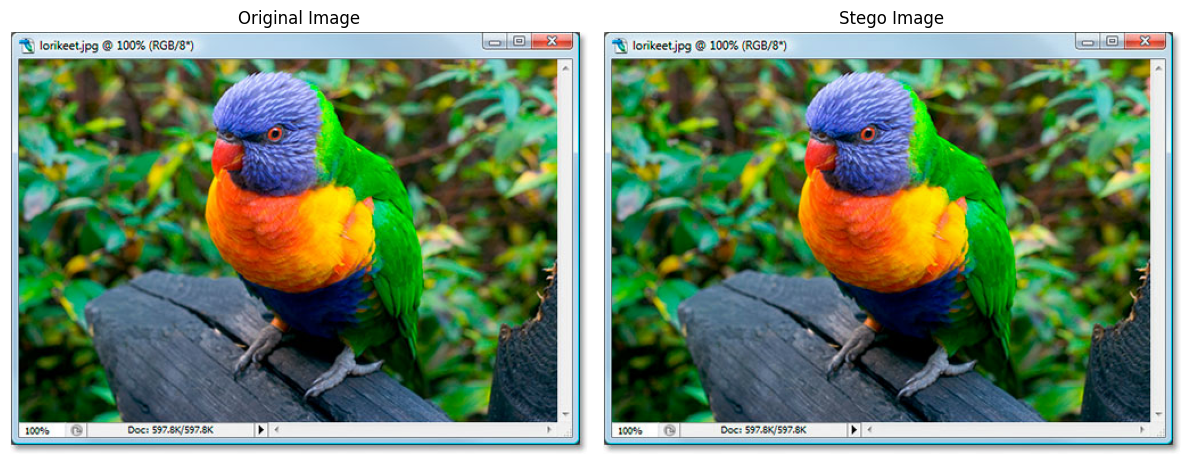

Original message: hello
Extracted message: 	
PSNR: 44.42 dB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

def rgb2ycbcr(im):
    """Convert RGB image to YCbCr."""
    xform = np.array([[.299, .587, .114],
                      [-.1687, -.3313, .5],
                      [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
    """Convert YCbCr image to RGB."""
    xform = np.array([[1, 0, 1.402],
                       [1, -0.34414, -.71414],
                       [1, 1.772, 0]])
    rgb = im.astype(np.float64)  # Changed from np.float to np.float64
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

def string_to_binary(message):
    """Convert string to binary."""
    binary = ''.join(format(ord(char), '08b') for char in message)
    return binary

def binary_to_string(binary):
    """Convert binary to string."""
    message = ""
    for i in range(0, len(binary), 8):
        byte = binary[i:i+8]
        message += chr(int(byte, 2))
    return message

def embed_lsb_dct(image, message, block_size=8, quant_factor=20):
    """Embed message using hybrid LSB-DCT approach."""
    # Convert message to binary
    binary_message = string_to_binary(message)
    binary_message += '0' * 8  # Add null terminator

    # Convert to YCbCr and work on Y channel for DCT
    if len(image.shape) == 3:
        ycbcr = rgb2ycbcr(image)
        y_channel = ycbcr[:,:,0].copy()
    else:
        y_channel = image.copy()

    height, width = y_channel.shape
    message_index = 0

    # Calculate how many blocks we need
    blocks_needed = len(binary_message)
    available_blocks = (height // block_size) * (width // block_size)

    if blocks_needed > available_blocks:
        raise ValueError(f"Message too long. Need {blocks_needed} blocks, but only {available_blocks} available.")

    # Embed data in DCT blocks
    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            if message_index >= len(binary_message):
                break

            # Extract block
            block = y_channel[i:i+block_size, j:j+block_size].astype(np.float32)

            # Apply DCT
            dct_block = cv2.dct(block)

            # Modify mid-frequency coefficient using LSB
            # We'll use the (4,3) coefficient as an example
            coef = dct_block[4, 3]
            # Round and convert to int
            coef_int = int(np.round(coef))

            # Replace LSB with message bit
            if message_index < len(binary_message):
                bit = int(binary_message[message_index])
                coef_int = (coef_int & ~1) | bit
                dct_block[4, 3] = float(coef_int)  # Using built-in float
                message_index += 1

            # Apply inverse DCT
            block = cv2.idct(dct_block)
            y_channel[i:i+block_size, j:j+block_size] = np.clip(block, 0, 255).astype(np.uint8)

    # Convert back to RGB if needed
    if len(image.shape) == 3:
        ycbcr[:,:,0] = y_channel
        stego_image = ycbcr2rgb(ycbcr)
    else:
        stego_image = y_channel

    return stego_image

def extract_lsb_dct(stego_image, block_size=8, max_message_len=1000):
    """Extract message using hybrid LSB-DCT approach."""
    # Convert to YCbCr and work on Y channel for DCT
    if len(stego_image.shape) == 3:
        ycbcr = rgb2ycbcr(stego_image)
        y_channel = ycbcr[:,:,0]
    else:
        y_channel = stego_image

    height, width = y_channel.shape
    binary_message = ""

    # Extract data from DCT blocks
    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            if len(binary_message) >= max_message_len * 8:
                break

            # Extract block
            block = y_channel[i:i+block_size, j:j+block_size].astype(np.float32)

            # Apply DCT
            dct_block = cv2.dct(block)

            # Extract from mid-frequency coefficient
            coef = dct_block[4, 3]
            coef_int = int(np.round(coef))
            bit = coef_int & 1
            binary_message += str(bit)

            # Check for null terminator
            if len(binary_message) >= 8 and binary_message[-8:] == '00000000':
                binary_message = binary_message[:-8]  # Remove null terminator
                return binary_to_string(binary_message)

    # If we reached here, we either didn't find a null terminator or read the whole image
    return binary_to_string(binary_message[:max_message_len*8])

def calculate_psnr(original, modified):
    """Calculate Peak Signal-to-Noise Ratio between two images."""
    mse = np.mean((original - modified) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Demo code for Google Colab
def main():
    # Upload image
    print("Please upload an image file:")
    uploaded = files.upload()

    filename = list(uploaded.keys())[0]
    cover_image = cv2.cvtColor(cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    # Get message from user
    message = input("Enter a message to hide: ")

    # Embed message
    stego_image = embed_lsb_dct(cover_image, message)

    # Extract message
    extracted_message = extract_lsb_dct(stego_image)

    # Calculate PSNR
    psnr_value = calculate_psnr(cover_image, stego_image)

    # Display results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cover_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(stego_image)
    plt.title("Stego Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Original message: {message}")
    print(f"Extracted message: {extracted_message}")
    print(f"PSNR: {psnr_value:.2f} dB")

    # Save stego image
    plt.imsave('stego_image.png', stego_image)
    files.download('stego_image.png')

if __name__ == "__main__":
    main()
else:
    main()  # Also run main() even if imported as a module